In [1]:
from darts.models import TFTModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
import utils
from darts import TimeSeries
import numpy as np
import pandas as pd
from darts.metrics import rmse
from darts.models import NaiveSeasonal
from darts.metrics import rmse, mape, r2_score
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
    Diff
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch

In [2]:
df = utils.load_data()


ts, covariates = utils.df2ts(df)

In [3]:
log_transformer = InvertibleMapper(
    fn=np.log1p, inverse_fn=np.expm1, name="log1p"
)
scaler = Scaler(StandardScaler())
filler = MissingValuesFiller()
differentiator = Diff(dropna=True)
pipeline = Pipeline([filler, scaler, differentiator])
covariates_pipeline = Pipeline([filler, scaler, differentiator])




covariates_scaled = covariates_pipeline.fit_transform(covariates)
ts_scaled = pipeline.fit_transform(ts)
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
val_ts = ts.drop_before(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

<Axes: xlabel='DATE'>

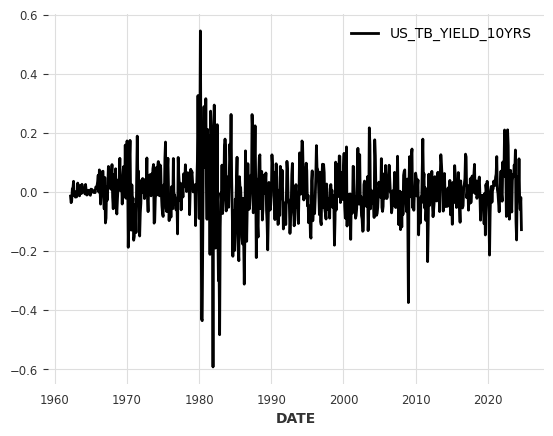

In [4]:
ts_scaled.plot()

In [5]:
from pytorch_lightning.callbacks import Callback


train_losses = []
val_losses = []

class LossAccumulatorCallback(Callback):
    """
    PyTorch Lightning Callback to accumulate training and validation losses per epoch.
    
    Attributes:
        train_losses (list): List to store training loss for each epoch.
        val_losses (list): List to store validation loss for each epoch.
    """
    
    def __init__(self):
        super().__init__()
    
    def on_train_epoch_end(self, trainer, pl_module):
        """
        Called when the train epoch ends.
        
        Args:
            trainer (pl.Trainer): The trainer instance.
            pl_module (pl.LightningModule): The model being trained.
        """
        # Retrieve the training loss from logged metrics
        # Assumes that 'train_loss' is the key used for logging training loss
        train_loss = trainer.callback_metrics.get('train_loss')
        
        if train_loss is not None:
            # Detach and move to CPU if necessary
            if isinstance(train_loss, torch.Tensor):
                train_loss = train_loss.detach().cpu().item()
            train_losses.append(train_loss)
            # print(f"Accumulated train_loss: {self.train_losses}")
        else:
            print("train_loss not found in callback_metrics.")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        
        if val_loss is not None:
            # Detach and move to CPU if necessary
            if isinstance(val_loss, torch.Tensor):
                val_loss = val_loss.detach().cpu().item()
            val_losses.append(val_loss)
        else:
            print("train_loss not found in callback_metrics.")
    

    def on_train_end(self, trainer, pl_module):
        """
        Called when the training ends.
        
        Args:
            trainer (pl.Trainer): The trainer instance.
            pl_module (pl.LightningModule): The model that was trained.
        """
        pass


In [6]:

quantiles = [
    # 0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    # 0.99,
]

input_chunk_length = 18
forecast_horizon = 12
model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=2,
    dropout=0.1,
    batch_size=32,
    n_epochs=10, #300,
    full_attention=True,
    add_relative_index=True,
    # log_tensorboard=True,
    # hidden_continuous_size=,
    # use_reversible_instance_norm=True,
    add_encoders={'cyclic': {'future': ['month']}},
    likelihood=QuantileRegression(quantiles=quantiles),  # QuantileRegression is set per default
    # loss_fn=torch.nn.MSELoss(),
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    pl_trainer_kwargs={"callbacks": [LossAccumulatorCallback()]}
)

In [32]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping

# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 6, 36)

    # Other hyperparameters
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 3)
    
    
    
    include_month = trial.suggest_categorical("month", [False, True])

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [pruner, early_stopper]

    # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 4
    else:
        num_workers = 0

    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": callbacks,
    }

    # optionally also add the (scaled) year value as a past covariate
    if include_month:
        encoders = {'cyclic': {'future': ['month']}} 
    else:
        encoders = None

    # reproducibility
    torch.manual_seed(42)

    input_chunk_length = 18
    forecast_horizon = 12
    model = TFTModel(
        model_name="tft_model",
        save_checkpoints=True,
        input_chunk_length=input_chunk_length,
        output_chunk_length=forecast_horizon,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        dropout=dropout,
        batch_size=32,
        n_epochs=20, #300,
        full_attention=True,
        add_relative_index=True,
        # log_tensorboard=True,
        # hidden_continuous_size=,
        # use_reversible_instance_norm=True,
        add_encoders=encoders,
        likelihood=QuantileRegression(quantiles=quantiles),  # QuantileRegression is set per default
        # loss_fn=torch.nn.MSELoss(),
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs=pl_trainer_kwargs
    )


    # # when validating during training, we can use a slightly longer validation
    # # set which also contains the first input_chunk_length time steps
    # model_val_set = scaler.transform(series[-(VAL_LEN + in_len) :])

    # train the model
    model.fit(
        series=train_ts_scaled,
        val_series=val_ts_scaled,
        past_covariates=train_covariates_scaled,
        val_past_covariates=val_covariates_scaled,
    )

    # reload best model over course of training
    model = TFTModel.load_from_checkpoint("tft_model")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train_ts_scaled, n=12)
    smapes = smape(val, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")



study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

[I 2024-12-22 23:29:45,246] A new study created in memory with name: no-name-f092c94f-0c43-4623-b94e-0cd2ca8d18be
[W 2024-12-22 23:29:45,261] Trial 0 failed with parameters: {'in_len': 29, 'dropout': 0.0390755131529355, 'lr': 0.00013957298716129308, 'hidden_size': 119, 'lstm_layers': 2, 'num_attention_heads': 2, 'month': True} because of the following error: TypeError("TorchForecastingModel.fit() got an unexpected keyword argument 'num_loader_workers'").
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_30470/3829345972.py", line 77, in objective
    model.fit(
  File "/opt/conda/lib/python3.11/site-packages/darts/utils/torch.py", line 80, in decorator
    return decorated(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: TorchForecastingModel.fit() got an unexpected keyword argument '

TypeError: TorchForecastingModel.fit() got an unexpected keyword argument 'num_loader_workers'

In [10]:
lr_find_results = model.lr_find(
        series=train_ts_scaled, 
        past_covariates=train_covariates_scaled,
        val_series=val_ts_scaled,
        val_past_covariates = val_covariates_scaled, 
        verbose=True
    )
# lr_find_results.plot(suggest=True, show=True)
lr_find_results.suggestion()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/sagemaker-user/code_Xavier/cdpq-ia/.lr_find_e83658d2-b0e7-48fe-9b07-c399c7964e9c.ckpt
Restored all states from the checkpoint at /home/sagemaker-user/code_Xavier/cdpq-ia/.lr_find_e83658d2-b0e7-48fe-9b07-c399c7964e9c.ckpt


0.0013182567385564075

In [7]:
model.fit(
        series=train_ts_scaled, 
        past_covariates=train_covariates_scaled,
        val_series=val_ts_scaled,
        val_past_covariates = val_covariates_scaled, 
        verbose=True
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.2 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 2.9 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 4.3 K  | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=1, num_attention_heads=2, full_attention=True, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=18, output_chunk_length=12, batch_size=32, n_epochs=10, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42, pl_trainer_kwargs={'callbacks': [<__main__.LossAccumulatorCallback object at 0x322583550>]})

In [8]:
import plotly.express as px


import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_training_history():
    # Create the figure
    fig = go.Figure()

    # Add traces for training and validation loss
    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(train_losses) + 1)),
            y=train_losses,
            name='Training Loss',
            line=dict(color='blue')
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(val_losses) + 1)),
            y=val_losses,
            name='Validation Loss',
            line=dict(color='red')
        )
    )

    # Update layout
    fig.update_layout(
        title='Training and Validation Loss Over Time',
        xaxis_title='Epoch',
        yaxis_title='Loss',
        hovermode='x unified',
        template='plotly_white'
    )

    # Show the plot
    fig.show()

plot_training_history()

In [9]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.05, 0.1, 0.9, 0.95
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [10]:
def hist_forecast_callback(counter, pred_time, train_series, past_covariates, future_covariates):
    print(pred_time)
    print(len(train_series))
    return False


fcast_scaled = model.historical_forecasts(
    series=ts_scaled,
    past_covariates=covariates_scaled,
    start = pd.Timestamp("2016-01-01"),
    forecast_horizon=1,
    verbose=True,
    num_samples=200,
    last_points_only=True,
    retrain=hist_forecast_callback,
    fit_kwargs={"epochs": 3}
)

2024-08-31 00:00:00
751


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/104 [00:00<?, ?it/s]

2016-01-31 00:00:00


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


647


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-02-29 00:00:00
648


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-03-31 00:00:00
649


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-04-30 00:00:00
650


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-05-31 00:00:00
651


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-06-30 00:00:00
652


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-07-31 00:00:00
653


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-08-31 00:00:00
654


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-09-30 00:00:00
655


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-10-31 00:00:00
656


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-11-30 00:00:00
657


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2016-12-31 00:00:00
658


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-01-31 00:00:00
659


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-02-28 00:00:00
660


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-03-31 00:00:00
661


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-04-30 00:00:00
662


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-05-31 00:00:00
663


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-06-30 00:00:00
664


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-07-31 00:00:00
665


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-08-31 00:00:00
666


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-09-30 00:00:00
667


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-10-31 00:00:00
668


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-11-30 00:00:00
669


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2017-12-31 00:00:00
670


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-01-31 00:00:00
671


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-02-28 00:00:00
672


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-03-31 00:00:00
673


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-04-30 00:00:00
674


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-05-31 00:00:00
675


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-06-30 00:00:00
676


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-07-31 00:00:00
677


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-08-31 00:00:00
678


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-09-30 00:00:00
679


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-10-31 00:00:00
680


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-11-30 00:00:00
681


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2018-12-31 00:00:00
682


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-01-31 00:00:00
683


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-02-28 00:00:00
684


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-03-31 00:00:00
685


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-04-30 00:00:00
686


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-05-31 00:00:00
687


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-06-30 00:00:00
688


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-07-31 00:00:00
689


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-08-31 00:00:00
690


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-09-30 00:00:00
691


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-10-31 00:00:00
692


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-11-30 00:00:00
693


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2019-12-31 00:00:00
694


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-01-31 00:00:00
695


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-02-29 00:00:00
696


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-03-31 00:00:00
697


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-04-30 00:00:00
698


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-05-31 00:00:00
699


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-06-30 00:00:00
700


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-07-31 00:00:00
701


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-08-31 00:00:00
702


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-09-30 00:00:00
703


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-10-31 00:00:00
704


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-11-30 00:00:00
705


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2020-12-31 00:00:00
706


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-01-31 00:00:00
707


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-02-28 00:00:00
708


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-03-31 00:00:00
709


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-04-30 00:00:00
710


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-05-31 00:00:00
711


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-06-30 00:00:00
712


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-07-31 00:00:00
713


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-08-31 00:00:00
714


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-09-30 00:00:00
715


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-10-31 00:00:00
716


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-11-30 00:00:00
717


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2021-12-31 00:00:00
718


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-01-31 00:00:00
719


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-02-28 00:00:00
720


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-03-31 00:00:00
721


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-04-30 00:00:00
722


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-05-31 00:00:00
723


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-06-30 00:00:00
724


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-07-31 00:00:00
725


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-08-31 00:00:00
726


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-09-30 00:00:00
727


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-10-31 00:00:00
728


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-11-30 00:00:00
729


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2022-12-31 00:00:00
730


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-01-31 00:00:00
731


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-02-28 00:00:00
732


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-03-31 00:00:00
733


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-04-30 00:00:00
734


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-05-31 00:00:00
735


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-06-30 00:00:00
736


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-07-31 00:00:00
737


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-08-31 00:00:00
738


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-09-30 00:00:00
739


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-10-31 00:00:00
740


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-11-30 00:00:00
741


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2023-12-31 00:00:00
742


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2024-01-31 00:00:00
743


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2024-02-29 00:00:00
744


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2024-03-31 00:00:00
745


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2024-04-30 00:00:00
746


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2024-05-31 00:00:00
747


Predicting: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [21]:
fcast = pipeline.inverse_transform(train_ts_scaled.append(fcast_scaled.mean()), partial=True)



model.backtest(series=ts, historical_forecasts=fcast, last_points_only=True)

6.045007210633853

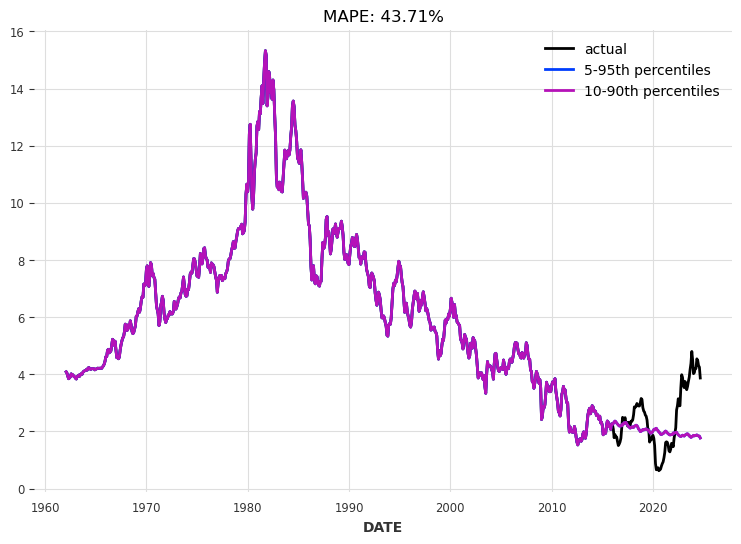

In [22]:
# plot actual series
plt.figure(figsize=figsize)
ts[: fcast.end_time()].plot(label="actual")

# plot prediction with quantile ranges
fcast.plot(
    low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
)
fcast.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

plt.title(f"MAPE: {mape(val_ts, fcast.mean()):.2f}%")
plt.legend()

In [ ]:
from darts.explainability import TFTExplainer


explainer = TFTExplainer(model)

explainability_result = explainer.explain()


explainer.plot_variable_selection(explainability_result)

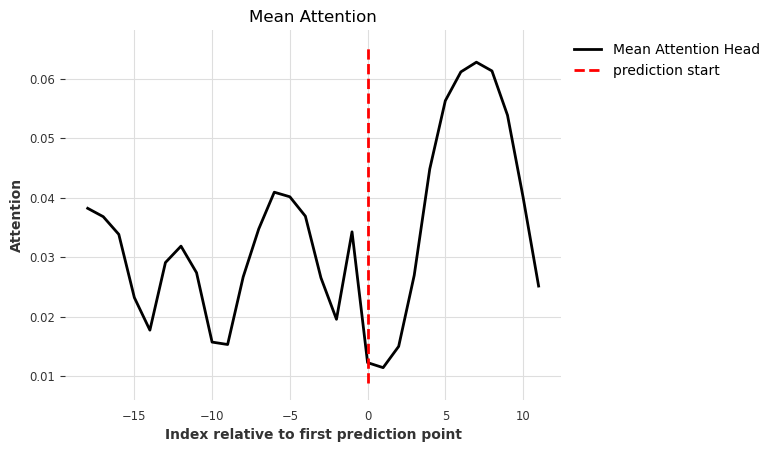

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [15]:
explainer.plot_attention(explainability_result, plot_type="time")